# Ising model analyses

_Copyright (C) 2023-, Joseph T. Lizier._
_Distributed under GNU General Public License v3_

This notebook template sets up reading in the data files for the Ising model simulations.

First code block is just to start up the JVM. You may need to change your paths below (use the AutoAnalyser to show them for you):

In [1]:
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("../../../demos/python")
import readIntsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "../../../infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

Next load in a sample data file and check that we can plot the spins at one time step ok.

Make sure that you have either downloaded and unzipped the [sample data](https://github.com/jlizier/jidt-cc-extras/raw/main/course/Module08-InfoTheoryAndSelfOrganisation/Ising/Ising-data.zip) or generated sample data. If generating yourself, then fix this range of temperatures that we have data files for:

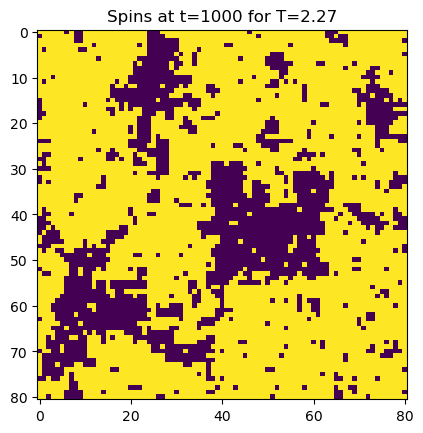

In [2]:
# We may want to loop over the data files later:
tempsToExamine = numpy.array([2.00, 2.20, 2.26, 2.27, 2.28, 2.29, 2.34, 2.54]);

# Check one data file - the way we reshape it into a grid may be useful for you to copy later:
sampleTemp = tempsToExamine[3];
filenameTemplate = './spins-%.2f.txt'
sampleDataFilename = filenameTemplate % sampleTemp

import os.path
if (not os.path.isfile(sampleDataFilename)):
    raise SystemExit("Ising model exported data files (e.g. %s) do not appear to exist in the current folder -- please fix this!" % sampleDataFilename)

dataRaw = readIntsFile.readIntsFile(sampleDataFilename)
# As numpy array:
data = numpy.array(dataRaw)
import math
modelSize = int(math.sqrt(data.shape[1]));
timeSteps = data.shape[0];
dataInLayout = numpy.zeros((timeSteps, modelSize, modelSize), dtype=int);
for t in range(timeSteps):
    # This reshapes in a transposed fashion to Matlab, but that doesn't matter for our purposes
    dataInLayout[t,:,:] = numpy.reshape(data[t,:], (modelSize, modelSize));

# Let's plot the last time step to check that it looks ok:
import matplotlib.pyplot as plt
plt.imshow( dataInLayout[timeSteps-1,:,:] )
plt.title('Spins at t=%d for T=%.2f' % (timeSteps, sampleTemp));

# Analysis 1 -- MI versus spatial distance and temperature

This analysis examines how MI between cells changes with spatial distance between the cells (explored via distance across the x-axis) -- at which temperatures does the system exhibit long-correlations?

The script also examines how this changes with temperature, to explore the phase transition as well. Can you see the effect of the phase transition brought out here? (For finite-sized systems, the transition point is usually offset from the theoretical critical point to higher temperatures).

The script may take several minutes to run:

In [3]:
# Compute MI vs x-separation for each temp:
misVsXDist = numpy.zeros((tempsToExamine.size, math.ceil(modelSize/2)));
for ti in range(tempsToExamine.size):
    # 0. Load/prepare the data:
    dataRaw = readIntsFile.readIntsFile(filenameTemplate % tempsToExamine[ti])
    data = numpy.array(dataRaw)
    timeSteps = data.shape[0];

    # Let's reshape the data so it's easier to work with
    dataInLayout = numpy.zeros((timeSteps, modelSize, modelSize), dtype=int);
    for t in range(timeSteps):
        # This reshapes in a transposed fashion to Matlab, but that doesn't matter for our purposes
        dataInLayout[t,:,:] = numpy.reshape(data[t,:], (modelSize, modelSize));
    
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(2, 2, 0)
    # 2. No other properties to set for discrete calculators.
    for xDiff in range(1,math.ceil(modelSize/2)+1):
        # We'll calculate MI for cells separated by xDiff
        # 3. Initialise the calculator for (re-)use:
        calc.initialise();
        for x in range(modelSize):
            for y in range(modelSize):
                # Column indices start from 0 in Python:
                source = dataInLayout[:,x,y];
                destination = dataInLayout[:,((x+xDiff) % modelSize),y];
                # 4. Supply the sample data:
                calc.addObservations(JArray(JInt, 1)(source.tolist()), JArray(JInt, 1)(destination.tolist()));
        # 5. Compute the estimate:
        # Note that we're placing the MI for xDiff in array index xDiff-1. Will correct this when plotting (below)
        misVsXDist[ti, xDiff-1] = calc.computeAverageLocalOfObservations();
    print('Done T=%.2f' % tempsToExamine[ti])
print('Computed MI for all distances at each temperature')

Done T=2.00
Done T=2.20
Done T=2.26
Done T=2.27
Done T=2.28
Done T=2.29
Done T=2.34
Done T=2.54
Computed MI for all distances at each temperature


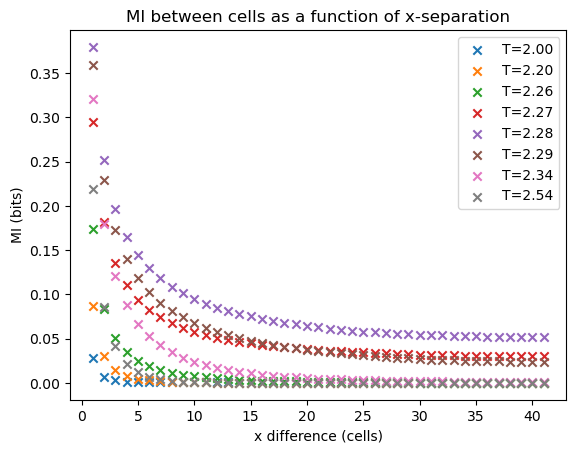

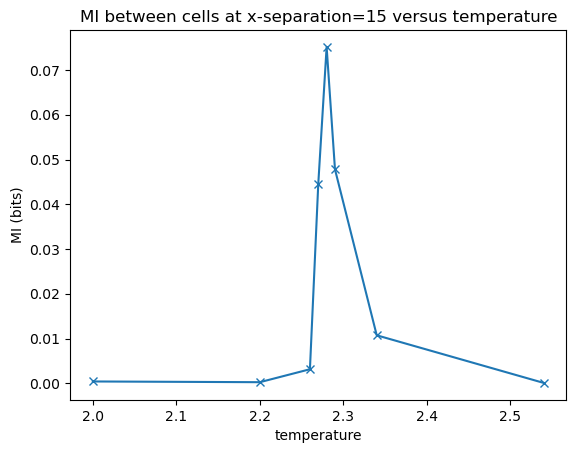

In [4]:
# Plot MI vs x-separation for each temp:plt.figure();
plt.figure();
for ti in range(tempsToExamine.size):
    # Add MI vs distance for this temperature:
    plt.scatter(range(1,math.ceil(modelSize/2)+1), misVsXDist[ti,], marker='x', label='T=%.2f' % tempsToExamine[ti])
plt.legend();
plt.title('MI between cells as a function of x-separation');
plt.ylabel('MI (bits)');
plt.xlabel('x difference (cells)');

# And plot MI vs temp for one sample distance:
distance = 15;
plt.figure();
plt.title('MI between cells at x-separation=%d versus temperature' % distance);
plt.ylabel('MI (bits)');
plt.xlabel('temperature');
plt.plot(tempsToExamine, misVsXDist[:,distance-1], marker='x')